3D TV-Regularized Sparse-View CT Reconstruction (Proximal ADMM Solver)
======================================================================

This example demonstrates solution of a sparse-view, 3D CT
reconstruction problem with isotropic total variation (TV)
regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $D$ is a 3D finite difference operator,
and $\mathbf{x}$ is the desired image.

In this example the problem is solved via proximal ADMM, while standard
ADMM is used in a [companion example](ct_astra_3d_tv_admm.rst).

In [1]:
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_tangle_phantom
from scico.linop.xray.astra import XRayTransform3D, angle_to_vector
from scico.optimize import ProximalADMM
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image and projector.

In [2]:
Nx = 128
Ny = 256
Nz = 64

tangle = snp.array(create_tangle_phantom(Nx, Ny, Nz))

n_projection = 10  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
det_spacing = [1.0, 1.0]
det_count = [Nz, max(Nx, Ny)]
vectors = angle_to_vector(det_spacing, angles)

C = XRayTransform3D(tangle.shape, det_count=det_count, vectors=vectors)  # CT projection operator
y = C @ tangle  # sinogram

Set up problem and solver. We want to minimize the functional

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is the convolution operator and $D$ is a finite difference
operator. This problem can be expressed as

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; (1/2) \| \mathbf{y} -
  \mathbf{z}_0 \|_2^2 + \lambda \| \mathbf{z}_1 \|_{2,1} \;\;
  \text{such that} \;\; \mathbf{z}_0 = C \mathbf{x} \;\; \text{and} \;\;
  \mathbf{z}_1 = D \mathbf{x} \;,$$

which can be written in the form of a standard ADMM problem

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; f(\mathbf{x}) + g(\mathbf{z})
  \;\; \text{such that} \;\; A \mathbf{x} + B \mathbf{z} = \mathbf{c}$$

with

  $$f = 0 \quad g = g_0 + g_1$$
  $$g_0(\mathbf{z}_0) = (1/2) \| \mathbf{y} - \mathbf{z}_0 \|_2^2 \quad
  g_1(\mathbf{z}_1) = \lambda \| \mathbf{z}_1 \|_{2,1}$$
  $$A = \left( \begin{array}{c} C \\ D \end{array} \right) \quad
  B = \left( \begin{array}{cc} -I & 0 \\ 0 & -I \end{array} \right) \quad
  \mathbf{c} = \left( \begin{array}{c} 0 \\ 0 \end{array} \right) \;.$$

This is a more complex splitting than that used in the
[companion example](ct_astra_3d_tv_admm.rst), but it allows the use of a
proximal ADMM solver in a way that avoids the need for the conjugate
gradient sub-iterations used by the ADMM solver in the
[companion example](ct_astra_3d_tv_admm.rst).

In [3]:
𝛼 = 1e2  # improve problem conditioning by balancing C and D components of A
λ = 2e0 / 𝛼  # ℓ2,1 norm regularization parameter
ρ = 5e-3  # ADMM penalty parameter
maxiter = 1000  # number of ADMM iterations

f = functional.ZeroFunctional()
g0 = loss.SquaredL2Loss(y=y)
g1 = λ * functional.L21Norm()
g = functional.SeparableFunctional((g0, g1))
D = linop.FiniteDifference(input_shape=tangle.shape, append=0)

A = linop.VerticalStack((C, 𝛼 * D))
mu, nu = ProximalADMM.estimate_parameters(A)

solver = ProximalADMM(
    f=f,
    g=g,
    A=A,
    B=None,
    rho=ρ,
    mu=mu,
    nu=nu,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 50},
)

Run the solver.

In [4]:
print(f"Solving on {device_info()}\n")
tangle_recon = solver.solve()
hist = solver.itstat_object.history(transpose=True)

print(
    "TV Restruction\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(tangle, tangle_recon), metric.mae(tangle, tangle_recon))
)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  3.13e+00  1.438e+04  3.358e+04  3.358e+04


  50  6.39e+00  3.979e+05  2.080e+04  3.847e+02


 100  8.67e+00  3.262e+05  1.236e+04  3.351e+02


 150  1.09e+01  2.910e+05  7.134e+03  2.676e+02


 200  1.33e+01  2.323e+05  4.149e+03  1.960e+02


 250  1.57e+01  2.152e+05  2.678e+03  1.547e+02


 300  1.80e+01  1.950e+05  1.900e+03  1.216e+02


 350  2.04e+01  1.876e+05  1.239e+03  1.011e+02


 400  2.27e+01  1.796e+05  7.456e+02  7.383e+01


 450  2.49e+01  1.740e+05  6.475e+02  5.413e+01


 500  2.71e+01  1.707e+05  6.710e+02  4.320e+01


 550  2.94e+01  1.699e+05  5.563e+02  3.627e+01


 600  3.18e+01  1.670e+05  3.992e+02  2.929e+01


 650  3.41e+01  1.665e+05  2.604e+02  2.339e+01


 700  3.63e+01  1.667e+05  1.622e+02  2.019e+01


 750  3.86e+01  1.652e+05  1.409e+02  1.623e+01


 800  4.09e+01  1.658e+05  1.480e+02  1.514e+01


 850  4.32e+01  1.649e+05  1.380e+02  1.324e+01


 900  4.55e+01  1.651e+05  1.093e+02  1.142e+01


 950  4.77e+01  1.649e+05  7.344e+01  9.757e+00


 999  4.99e+01  1.648e+05  4.437e+01  8.498e+00


TV Restruction
SNR: 21.24 (dB), MAE: 0.009


Show the recovered image.

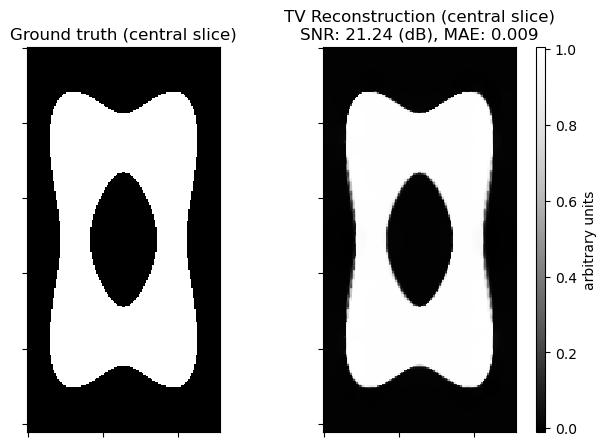

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(7, 5))
plot.imview(tangle[32], title="Ground truth (central slice)", cbar=None, fig=fig, ax=ax[0])

plot.imview(
    tangle_recon[32],
    title="TV Reconstruction (central slice)\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(tangle, tangle_recon), metric.mae(tangle, tangle_recon)),
    fig=fig,
    ax=ax[1],
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[1].get_images()[0], cax=cax, label="arbitrary units")
fig.show()